In [176]:
import cv2, os
import numpy as np
import matplotlib.image as mpimg


IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)


def load_image(image_path):
    """
    Load RGB images from a file
    """
    return mpimg.imread("IMG/"+image_path)


def crop(image):
    """
    Crop the image (removing the sky at the top and the car front at the bottom)
    """
    return image[60:-25, :, :] # remove the sky and the car front


def resize(image):
    """
    Resize the image to the input shape used by the network model
    """
    return cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)


def rgb2yuv(image):
    """
    Convert the image from RGB to YUV (This is what the NVIDIA model does)
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)


def preprocess(image):
    """
    Combine all preprocess functions into one
    """
    image = crop(image)
    image = resize(image)
    image = rgb2yuv(image)
    return image


def choose_image(center, left, right, steering_angle):
    """
    Randomly choose an image from the center, left or right, and adjust
    the steering angle.
    """
    choice = np.random.choice(3)
    if choice == 0:
        return load_image(left), steering_angle  + 0.2
    elif choice == 1:
        return load_image(right), steering_angle - 0.2
    return load_image(center), steering_angle


def random_flip(image, steering_angle):
    """
    Randomly flipt the image left <-> right, and adjust the steering angle.
    """
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        steering_angle = -steering_angle
    return image, steering_angle

def random_translate(image, steering_angle, range_x, range_y):
    """
    Randomly shift the image virtially and horizontally (translation).
    """
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    steering_angle += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, steering_angle


def random_shadow(image):
    """
    Generates and adds random shadow
    """
    # (x1, y1) and (x2, y2) forms a line
    # xm, ym gives all the locations of the image
    x1, y1 = image.shape[1] * np.random.rand(), 0
    x2, y2 = image.shape[1] * np.random.rand(), image.shape[0]
    xm, ym = np.mgrid[0:image.shape[0], 0:image.shape[1]]

    # mathematically speaking, we want to set 1 below the line and zero otherwise
    # Our coordinate is up side down.  So, the above the line: 
    # (ym-y1)/(xm-x1) > (y2-y1)/(x2-x1)
    # as x2 == x1 causes zero-division problem, we'll write it in the below form:
    # (ym-y1)*(x2-x1) - (y2-y1)*(xm-x1) > 0
    mask = np.zeros_like(image[:, :, 1])
    mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1

    # choose which side should have shadow and adjust saturation
    cond = mask == np.random.randint(2)
    s_ratio = np.random.uniform(low=0.2, high=0.5)

    # adjust Saturation in HLS(Hue, Light, Saturation)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
    return cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)


def random_brightness(image):
    """
    Randomly adjust brightness of the image.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)


def augument(center, left, right, steering_angle, range_x = 100, range_y = 10):
    """
    Generate an augumented image and adjust steering angle.
    (The steering angle is associated with the center image)
    """
    image, steering_angle = choose_image(center, left, right, steering_angle)
    image, steering_angle = random_flip(image, steering_angle)
    image, steering_angle = random_translate(image, steering_angle, range_x, range_y)
    image = random_shadow(image)
    plt.imshow(image)
    image = random_brightness(image)
    return image, steering_angle


def batch_generator(data, steering_angles, batch_size, is_training):
    """
    Generate training image give image paths and associated steering angles
    """
    images = np.empty([batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
    steers = np.empty(batch_size)
    while True:
        i = 0
        for index in np.random.permutation(len(data)):
            center, left, right = data[index]
            steering_angle = steering_angles[index]
            # argumentation
            if is_training and np.random.rand() < 0.6:
                image, steering_angle = augument(center, left, right, steering_angle)
            else:
                image =  load_image(center)
            # add the image and steering angle to the batch
            images[i] = preprocess(image)
            steers[i] = steering_angle
            i += 1
            if i == batch_size:
                break
        yield images, steers



In [179]:
import pandas as pd
df = pd.read_csv('driving_log.csv')

In [180]:
data_df = pd.read_csv(('driving_log.csv'), names = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'])


In [181]:
data_df


,center,left,right,steering,throttle,reverse,speed
0,/Users/amankumar/Desktop/self/IMG/center_2020_...,/Users/amankumar/Desktop/self/IMG/left_2020_04...,/Users/amankumar/Desktop/self/IMG/right_2020_0...,0.0,0.000000,0.000000,7.639537
1,/Users/amankumar/Desktop/self/IMG/center_2020_...,/Users/amankumar/Desktop/self/IMG/left_2020_04...,/Users/amankumar/Desktop/self/IMG/right_2020_0...,0.0,0.000000,0.000000,7.562862
2,/Users/amankumar/Desktop/self/IMG/center_2020_...,/Users/amankumar/Desktop/self/IMG/left_2020_04...,/Users/amankumar/Desktop/self/IMG/right_2020_0...,0.0,0.214878,0.000000,7.612742
3,/Users/amankumar/Desktop/self/IMG/center_2020_...,/Users/amankumar/Desktop/self/IMG/left_2020_04...,/Users/amankumar/Desktop/self/IMG/right_2020_0...,0.0,0.461520,0.000000,7.987578
4,/Users/amankumar/Desktop/self/IMG/center_2020_...,/Users/amankumar/Desktop/self/IMG/left_2020_04...,/Users/amankumar/Desktop/self/IMG/right_2020_0...,0.0,0.711216,0.000000,8.504250
...,...,...,...,...,...,...,...
1989,/Users/amankumar/Desktop/self/IMG/center_2020_...,/Users/amankumar/Desktop/self/IMG/left_2020_04...,/Users/amankumar/Desktop/self/IMG/right_2020_0...,0.0,0.000000,1.000000,20.169910
1990,/Users/amankumar/Desktop/self/IMG/center_2020_...,/Users/amankumar/Desktop/self/IMG/left_2020_04...,/Users/amankumar/Desktop/self/IMG/right_2020_0...,0.0,0.000000,1.000000,18.853430
1991,/Users/amankumar/Desktop/self/IMG/center_2020_...,/Users/amankumar/Desktop/self/IMG/left_2020_04...,/Users/amankumar/Desktop/self/IMG/right_2020_0...,0.0,0.000000,1.000000,17.551940
1992,/Users/amankumar/Desktop/self/IMG/center_2020_...,/Users/amankumar/Desktop/self/IMG/left_2020_04...,/Users/amankumar/Desktop/self/IMG/right_2020_0...,0.0,0.000000,1.000000,15.945900


In [150]:
a1 = data_df['center'][34].split('/')
a1[6]

'center_2020_04_01_20_18_47_404.jpg'

In [151]:
image = load_image(str(a1[6]))

In [152]:
import matplotlib.pyplot as plt

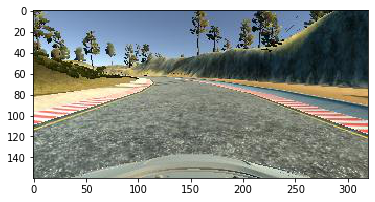

In [153]:
plt.imshow(image)

In [154]:
image = preprocess(image)

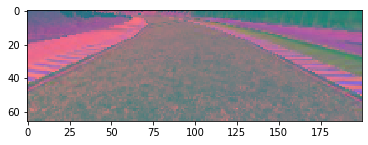

In [155]:
plt.imshow(image)

In [156]:
image = random_shadow(image)

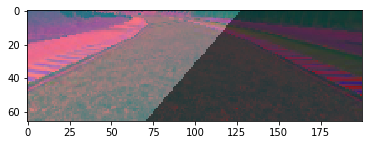

In [157]:
plt.imshow(image)

In [158]:
image , sr = random_translate(image,10,100,100)

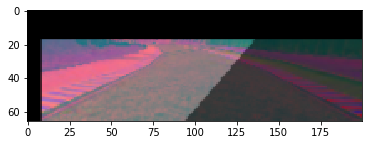

In [159]:
plt.imshow(image)

In [160]:
image = random_brightness(image)

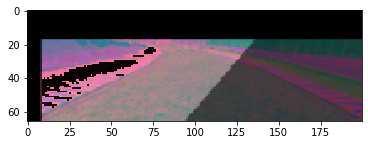

In [161]:
plt.imshow(image)

In [162]:
data_df


,center,left,right,steering,throttle,reverse,speed
0,/Users/amankumar/Desktop/self/IMG/center_2020_...,/Users/amankumar/Desktop/self/IMG/left_2020_04...,/Users/amankumar/Desktop/self/IMG/right_2020_0...,0.0,0.0,0,0.000016
1,/Users/amankumar/Desktop/self/IMG/center_2020_...,/Users/amankumar/Desktop/self/IMG/left_2020_04...,/Users/amankumar/Desktop/self/IMG/right_2020_0...,0.0,0.0,0,0.000014
2,/Users/amankumar/Desktop/self/IMG/center_2020_...,/Users/amankumar/Desktop/self/IMG/left_2020_04...,/Users/amankumar/Desktop/self/IMG/right_2020_0...,0.0,0.0,0,0.000013
3,/Users/amankumar/Desktop/self/IMG/center_2020_...,/Users/amankumar/Desktop/self/IMG/left_2020_04...,/Users/amankumar/Desktop/self/IMG/right_2020_0...,0.0,0.0,0,0.000029
4,/Users/amankumar/Desktop/self/IMG/center_2020_...,/Users/amankumar/Desktop/self/IMG/left_2020_04...,/Users/amankumar/Desktop/self/IMG/right_2020_0...,0.0,0.0,0,0.000008
...,...,...,...,...,...,...,...
3658,/Users/amankumar/Desktop/self/IMG/center_2020_...,/Users/amankumar/Desktop/self/IMG/left_2020_04...,/Users/amankumar/Desktop/self/IMG/right_2020_0...,0.0,0.0,0,26.329510
3659,/Users/amankumar/Desktop/self/IMG/center_2020_...,/Users/amankumar/Desktop/self/IMG/left_2020_04...,/Users/amankumar/Desktop/self/IMG/right_2020_0...,0.0,0.0,0,26.114470
3660,/Users/amankumar/Desktop/self/IMG/center_2020_...,/Users/amankumar/Desktop/self/IMG/left_2020_04...,/Users/amankumar/Desktop/self/IMG/right_2020_0...,0.0,0.0,0,25.901510
3661,/Users/amankumar/Desktop/self/IMG/center_2020_...,/Users/amankumar/Desktop/self/IMG/left_2020_04...,/Users/amankumar/Desktop/self/IMG/right_2020_0...,0.0,0.0,0,25.690790


In [184]:
data = []
steering_angle = []
for i in range(len(data_df)):
    a1 = data_df['center'][i].split('/')
    data_df['center'][i] = a1[-1]
    a1 = data_df['left'][i].split('/')
    data_df['left'][i] = a1[-1]
    a1 = data_df['right'][i].split('/')
    data_df['right'][i] = a1[-1]
    b = []
    image = mpimg.imread("IMG/"+data_df['center'][i])
    b.append(image)
    image = mpimg.imread("IMG/"+data_df['left'][i])
    b.append(image)
    image = mpimg.imread("IMG/"+data_df['right'][i])
    b.append(image)
    data.append(b)
    steering_angle.append(data_df['steering'][i])
    

/Users/amankumar/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/amankumar/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/amankumar/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [164]:
import pickle 
with open ("data.txt","wb") as fp:
    pickle.dump(data,fp)

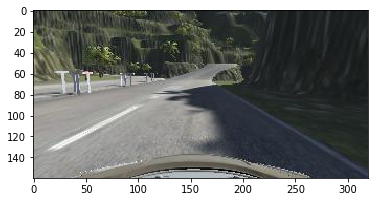

In [185]:
plt.imshow(data[1][0])

In [166]:
# with open ("steering_angle.txt","wb") as fp:
#     pickle.dump(steering_angle,fp)

In [171]:
import matplotlib.pyplot as plt

In [168]:

# hist,bins = np.histogram(steering_angle,bins = 25)
# center = bins[:-1] + bins[1:] * 0.5  # center the bins to 0

# ## Plot
# samples_per_bin = 200
# plt.bar(center, hist, width=0.05)
# plt.plot((np.min(data_df['steering']), np.max(data_df['steering'])), (samples_per_bin, samples_per_bin))

In [169]:
# print('Total data: {0}'.format(len(data)))
# from random import shuffle
# ## Make list of indices to remove
# remove_list = []
# num_bins = 25
# for j in range(num_bins):
#     list_ = []
#     for i in range(len(data_df['steering'])):
#         steering_angle = data_df['steering'][i]
#     if steering_angle >= bins[j] and steering_angle <= bins[j+1]: 
#         list_.append(i)
#         print(i)
#     if list_ is not None:
#         list_ = list_[samples_per_bin:]
#         remove_list.extend(list_)
# data_df.drop(data_df.index[remove_list], inplace=True)
# print('Removed: {0}'.format(len(remove_list)))
# print('Remaining: {0}'.format(len(data_df)))

# ## Plot
# hist, _ = np.histogram(data_df['steering'], (num_bins))
# plt.bar(center, hist, width=0.05)
# plt.plot((np.min(data_df['steering']), np.max(data_df['steering'])), (samples_per_bin, samples_per_bin))

In [186]:

data_df

,center,left,right,steering,throttle,reverse,speed
0,center_2020_04_03_18_16_23_474.jpg,left_2020_04_03_18_16_23_474.jpg,right_2020_04_03_18_16_23_474.jpg,0.0,0.000000,0.000000,7.639537
1,center_2020_04_03_18_16_23_569.jpg,left_2020_04_03_18_16_23_569.jpg,right_2020_04_03_18_16_23_569.jpg,0.0,0.000000,0.000000,7.562862
2,center_2020_04_03_18_16_23_640.jpg,left_2020_04_03_18_16_23_640.jpg,right_2020_04_03_18_16_23_640.jpg,0.0,0.214878,0.000000,7.612742
3,center_2020_04_03_18_16_23_722.jpg,left_2020_04_03_18_16_23_722.jpg,right_2020_04_03_18_16_23_722.jpg,0.0,0.461520,0.000000,7.987578
4,center_2020_04_03_18_16_23_806.jpg,left_2020_04_03_18_16_23_806.jpg,right_2020_04_03_18_16_23_806.jpg,0.0,0.711216,0.000000,8.504250
...,...,...,...,...,...,...,...
1989,center_2020_04_03_18_19_01_778.jpg,left_2020_04_03_18_19_01_778.jpg,right_2020_04_03_18_19_01_778.jpg,0.0,0.000000,1.000000,20.169910
1990,center_2020_04_03_18_19_01_861.jpg,left_2020_04_03_18_19_01_861.jpg,right_2020_04_03_18_19_01_861.jpg,0.0,0.000000,1.000000,18.853430
1991,center_2020_04_03_18_19_01_946.jpg,left_2020_04_03_18_19_01_946.jpg,right_2020_04_03_18_19_01_946.jpg,0.0,0.000000,1.000000,17.551940
1992,center_2020_04_03_18_19_02_037.jpg,left_2020_04_03_18_19_02_037.jpg,right_2020_04_03_18_19_02_037.jpg,0.0,0.000000,1.000000,15.945900


In [173]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from utils import INPUT_SHAPE, batch_generator
import argparse
import os


In [70]:
# from keras.applications.resnet50 import ResNet50
# resnet = ResNet50(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
# for layer in resnet.layers[:-4]:
#     layer.trainable = False

In [76]:
model= Sequential()
model.add(Lambda(lambda x: x/127.5-1.0, input_shape=INPUT_SHAPE))
model.add(Conv2D(24, kernel_size = (5, 5), activation='elu', strides =  (2, 2)))
model.add(Conv2D(36, kernel_size =  (5, 5), activation='elu',  strides  =  (2, 2)))
model.add(Conv2D(48, kernel_size = (5, 5), activation='elu', strides =  (2, 2)))
model.add(Conv2D(64, kernel_size = (3, 3), activation='elu'))
model.add(Conv2D(64, kernel_size = (3, 3), activation='elu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation='elu'))
model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))
optimizer = Adam(lr=1e-3)
model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 18, 64)        

In [187]:
X = data_df[['center', 'left', 'right']].values
y = data_df['steering'].values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 0)

/Users/amankumar/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if __name__ == '__main__':
/Users/amankumar/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=39, epochs=10, validation_data=<generator..., callbacks=[<keras.ca..., verbose=1, validation_steps=399, max_queue_size=1)`
  if __name__ == '__main__':


Epoch 1/10
39/39 [==============================] - 49s 1s/step - loss: 0.1146 - accuracy: 0.2564 - val_loss: 0.0663 - val_accuracy: 0.5566

Epoch 00001: val_loss did not improve from 0.00853
Epoch 2/10
39/39 [==============================] - 47s 1s/step - loss: 0.1141 - accuracy: 0.2442 - val_loss: 0.0799 - val_accuracy: 0.5604

Epoch 00002: val_loss did not improve from 0.00853
Epoch 3/10
39/39 [==============================] - 46s 1s/step - loss: 0.1201 - accuracy: 0.2596 - val_loss: 0.1054 - val_accuracy: 0.5622

Epoch 00003: val_loss did not improve from 0.00853
Epoch 4/10
39/39 [==============================] - 46s 1s/step - loss: 0.1245 - accuracy: 0.2282 - val_loss: 0.1015 - val_accuracy: 0.5625

Epoch 00004: val_loss did not improve from 0.00853
Epoch 5/10
39/39 [==============================] - 46s 1s/step - loss: 0.1145 - accuracy: 0.2487 - val_loss: 0.1463 - val_accuracy: 0.5532

Epoch 00005: val_loss did not improve from 0.00853
Epoch 6/10
39/39 [======================

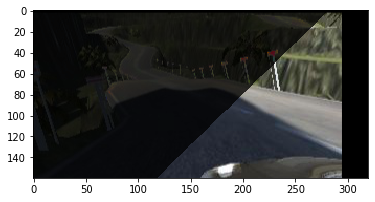

In [191]:
# checkpoint = ModelCheckpoint('model3.h5',monitor = 'val_loss',  verbose = 1, save_best_only = True,mode='auto')
# from keras.callbacks import EarlyStopping, ReduceLROnPlateau
# earlystop = EarlyStopping(patience=10)
# learning_rate_reduction = ReduceLROnPlateau(monitor = 'loss', 
#                                             patience = 2, 
#                                             verbose = 1, 
#                                             factor = 0.5, 
#                                             min_lr = 0.0001)
model.fit_generator(batch_generator( X_train, y_train, 40, True),steps_per_epoch =(len(X_train)//40), epochs = 10 , validation_data = batch_generator(X_valid, y_valid, 40 , False),nb_val_samples = len(X_valid), max_q_size = 1 ,callbacks = [checkpoint,learning_rate_reduction,earlystop],  verbose = 1)
                                    
                                    
                                                   
                                                    
                                                    
                                                     
                                                    
                                                   

In [77]:
model.load_weights('model3.h5')

In [192]:
model.save("model3.h5")